# Model Training - Credit Card Fraud Detection

##  Objective
In this notebook, we will:
- Load the preprocessed datasets (undersampled, oversampled)
- Train multiple supervised models for fraud detection
- Compare their performance using key evaluation metrics
- Identify the best-performing model for deployment



In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay
    
)
from sklearn.metrics import  precision_recall_curve
from sklearn.model_selection import cross_val_predict
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8")
sns.set_palette("coolwarm")


In [2]:
df = pd.read_csv("../data/processed/creditcard_undersampled.csv")

In [3]:
X = df.drop('Class', axis=1)
y = df['Class']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [6]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "xgboost": XGBClassifier(),
}

In [7]:
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 93.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 92.0 % accuracy score
Classifiers:  SVC Has a training score of 93.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 91.0 % accuracy score
Classifiers:  RandomForestClassifier Has a training score of 94.0 % accuracy score
Classifiers:  XGBClassifier Has a training score of 94.0 % accuracy score


Logistic Regression, KNNand random forest  classifiers are more accurate than the other classifiers in most cases. (We will further analyze those calissifiers)

In [8]:
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)

log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

# RandomForest Classifier
forest_params = {"n_estimators": [50, 100], "criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1))}
grid_forest = GridSearchCV(RandomForestClassifier(), forest_params)
grid_forest.fit(X_train, y_train)   
# forest best estimator
forest_clf = grid_forest.best_estimator_    
# XGBoost Classifier
xgb_params = {"learning_rate": [0.01, 0.1, 0.2], "n_estimators": [50, 100, 200], "max_depth": [3, 5, 7]}
grid_xgb = GridSearchCV(XGBClassifier(), xgb_params)
grid_xgb.fit(X_train, y_train)
# xgb best estimator
xgb_clf = grid_xgb.best_estimator_  



In [9]:
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

forest_score = cross_val_score(forest_clf, X_train, y_train, cv=5)
print('RandomForest Classifier Cross Validation Score', round(forest_score.mean() * 100, 2).astype(str) + '%')  

xgb_score = cross_val_score(xgb_clf, X_train, y_train, cv=5) 
print('XGBoost Classifier Cross Validation Score', round(xgb_score.mean() * 100, 2).astype(str) + '%')


Logistic Regression Cross Validation Score:  94.16%
Knears Neighbors Cross Validation Score 92.63%
Support Vector Classifier Cross Validation Score 94.02%
DecisionTree Classifier Cross Validation Score 91.65%
RandomForest Classifier Cross Validation Score 92.77%
XGBoost Classifier Cross Validation Score 94.16%


In [10]:
# We will undersample during cross validating

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique 
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
# use fit_resample() instead of deprecated fit_sample()
X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# Cross Validating the right way

for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # NearMiss happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    # use the undersampled train/validation splits for scoring and metrics consistently
    undersample_accuracy.append(undersample_pipeline.score(undersample_Xtrain[test], undersample_ytrain[test]))
    undersample_precision.append(precision_score(undersample_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(undersample_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(undersample_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(undersample_ytrain[test], undersample_prediction))

Train: [390 260 669 674   4 662 562 272 293 275 311 761 769 882  13 598 200 351
 768 206 631 288   1 126 366 224 763 295 404 802 850 205 274 636 144 807
 503 423 705 835 140  35 740 493 265 173 805 866  53 747 657 827 772 291
 172 412 572 825 304  59 803 700 128 259 430 281 893 684 124 465 880 188
 626 216  41 170 131 441 722 634 182 411   3 592 253 539 192 138  72 107
 269 379 668 287 401 560 574 231  32 197 385  88 581 452 266 374 460 499
 836 780 881 456 413 238 764 751 223 115 555  14 309 284 199 424 496 463
 548  33 553 618 234 832 166 697 270 714 489 345 527 318 892 116 659 765
 860 651 384  58 139 642 312 111 478 564 713 688 167 831 875 753 620 330
 799  47 202 382 712 873 118 308 889 277 719 645 538  62 755 517 279 809
 723  86 320 584 737 707  45 648 433 531  43 132 106  67 715 492 361 482
 528 332 114  27 726 378 532 227  52 410 445   6 760 397 350 838 794 797
 303 666 630 286  82 551   5 317 466 484 267 558 103 229 283 178  16 699
 523 804 342 428 588 627 750 594 650 796 644

In [11]:


def plot_learning_curves(models, model_names, X, y, cv=None, n_jobs=-1, 
                         train_sizes=np.linspace(0.1, 1.0, 5), figsize=(20, 20)):
    

    num_models = len(models)
    rows = int(np.ceil(num_models / 2))  # 2 columns layout
    fig, axes = plt.subplots(rows, 2, figsize=figsize)
    axes = axes.flatten()  # flatten to iterate easily

    for i, (model, name) in enumerate(zip(models, model_names)):
        ax = axes[i]

        train_sizes_abs, train_scores, test_scores = learning_curve(
            model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
        )

        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)

        ax.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std,
                        alpha=0.1, color="#ff9124")
        ax.fill_between(train_sizes_abs, test_mean - test_std, test_mean + test_std,
                        alpha=0.1, color="#2492ff")
        ax.plot(train_sizes_abs, train_mean, 'o-', color="#ff9124", label="Training score")
        ax.plot(train_sizes_abs, test_mean, 'o-', color="#2492ff", label="Cross-validation score")

        ax.set_title(f"{name} Learning Curve", fontsize=14)
        ax.set_xlabel('Training examples')
        ax.set_ylabel('Score')
        ax.grid(True)
        ax.legend(loc="best")

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


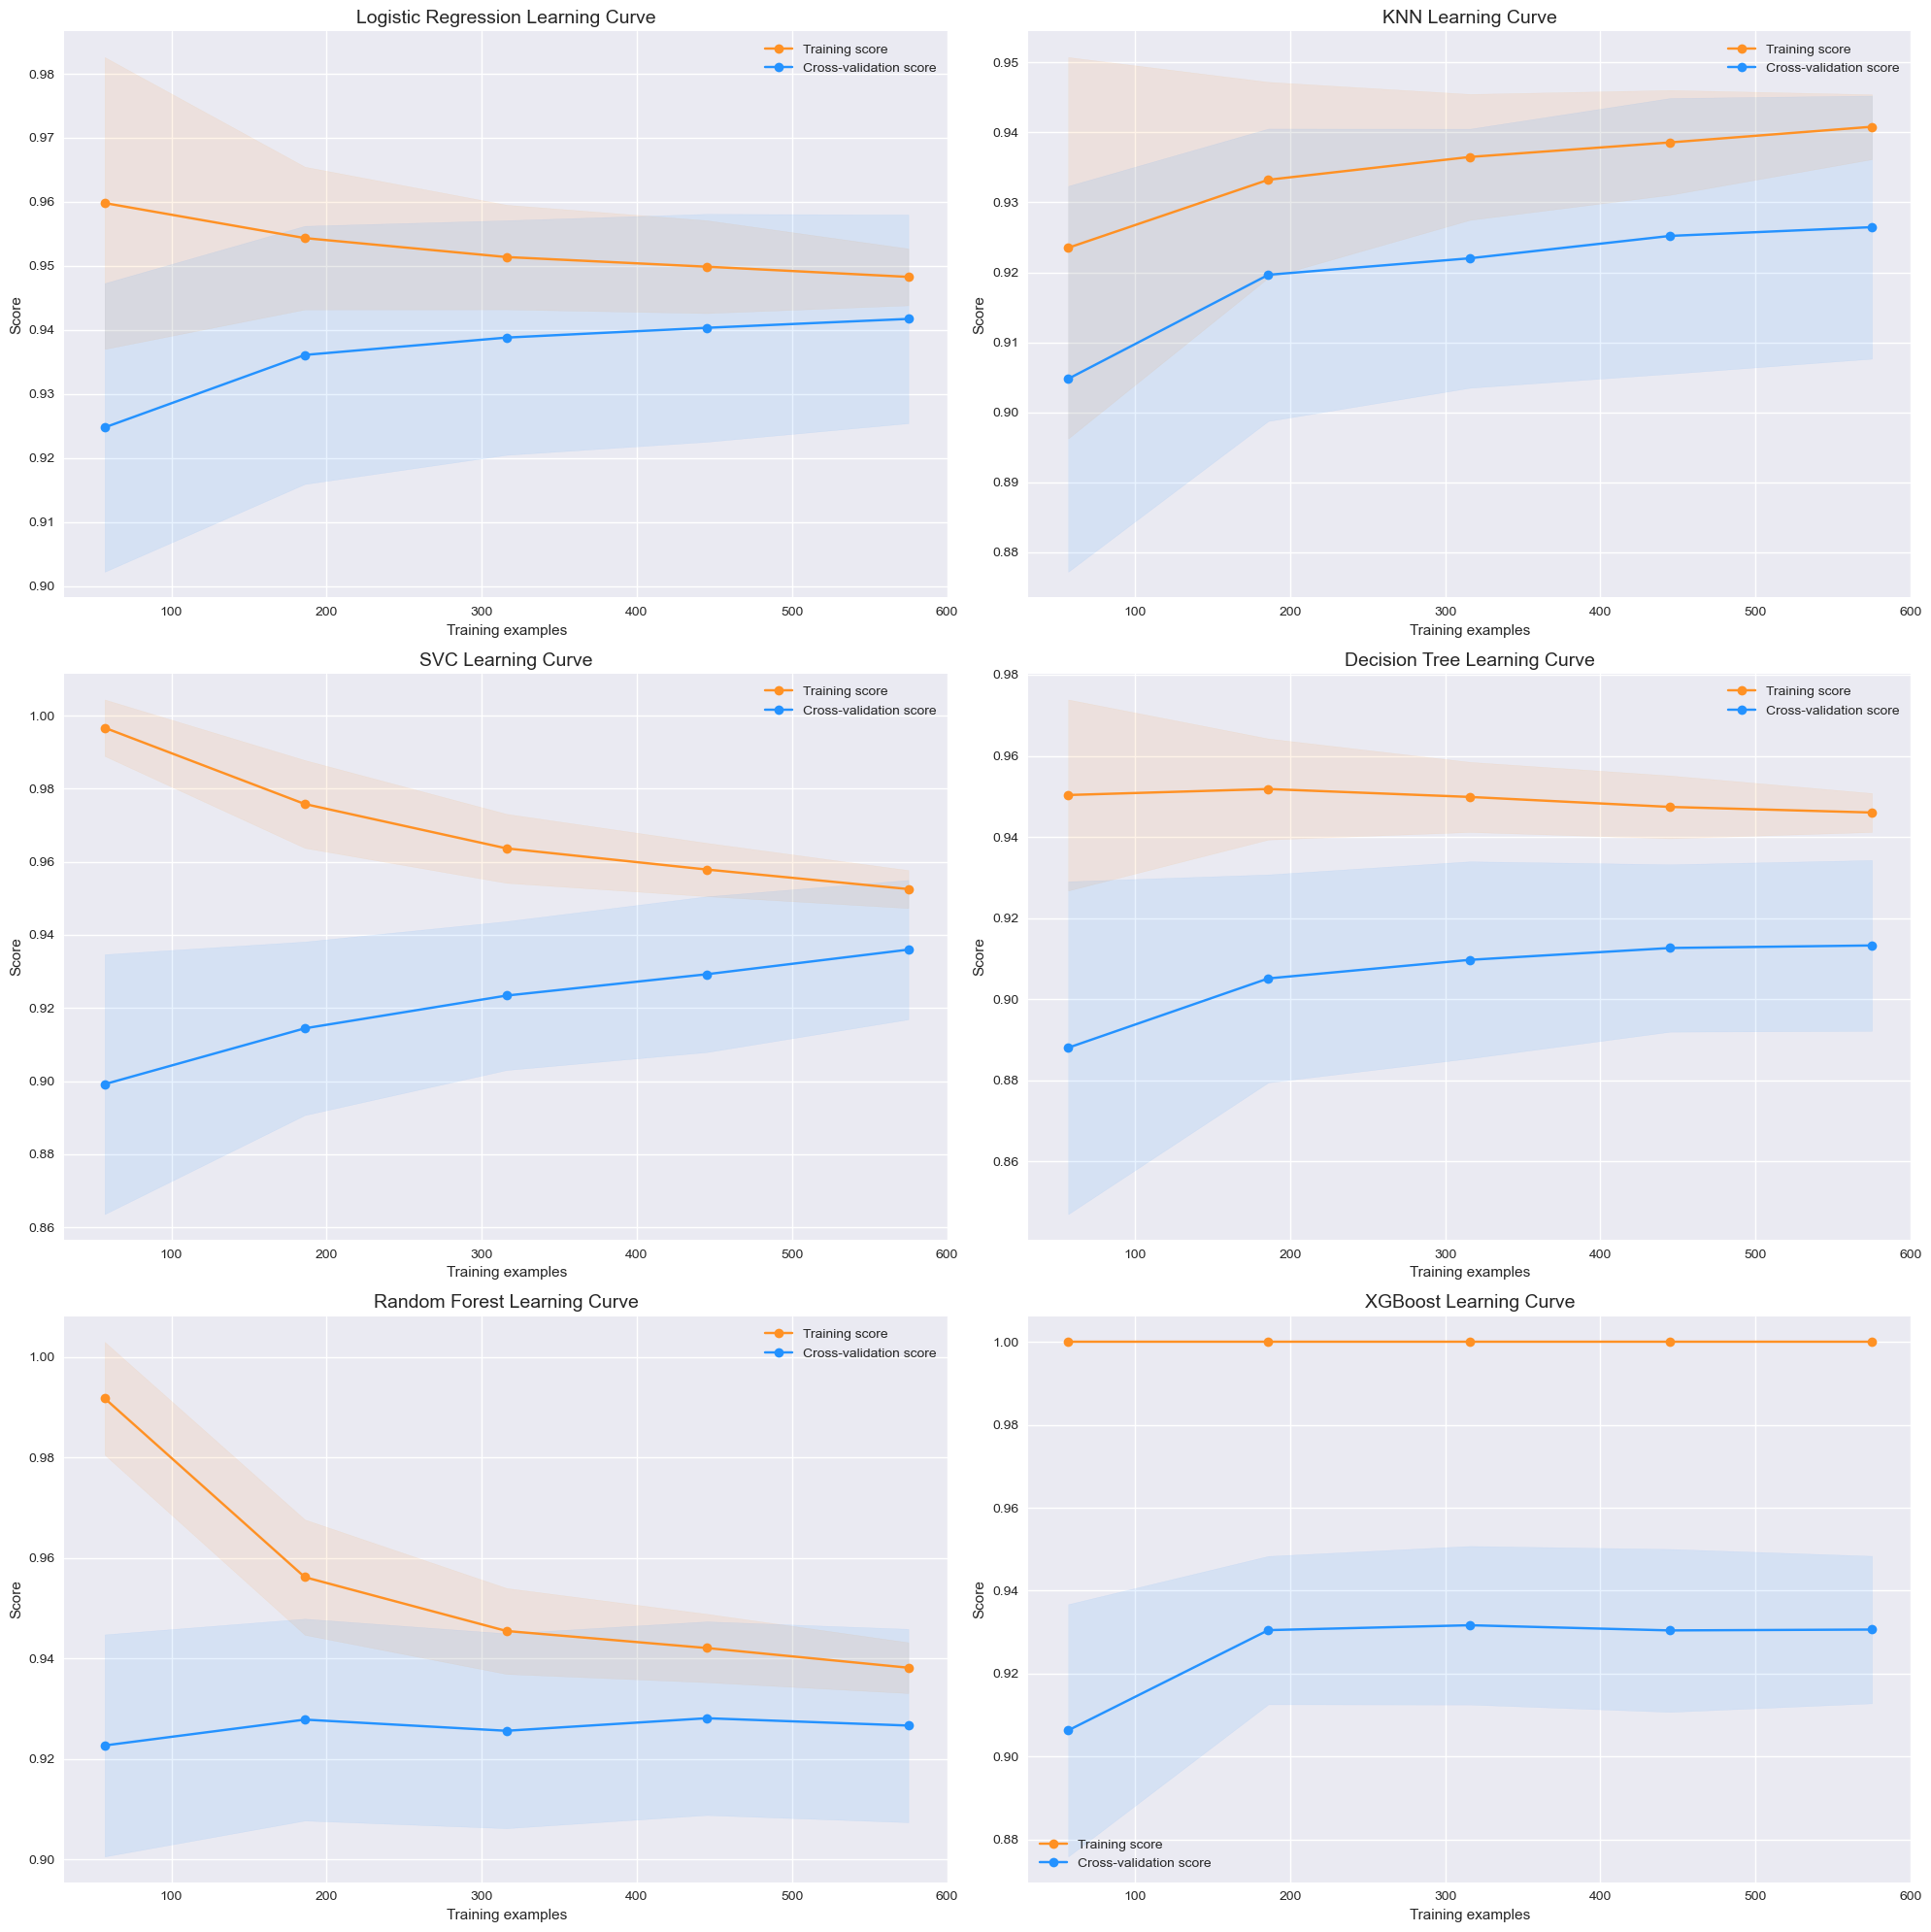

In [12]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curves(
    models=[log_reg, knears_neighbors, svc, tree_clf, forest_clf, xgb_clf],
    model_names=["Logistic Regression", "KNN", "SVC", "Decision Tree", "Random Forest", "XGBoost"],
    X=X_train,
    y=y_train,
    cv=cv,
    n_jobs=4
)

- The wider the gap between the training score and the cross validation score, the more likely your model is overfitting (high variance).
- If the score is low in both training and cross-validation sets this is an indication that our model is underfitting (high bias)
- Logistic Regression Classifier shows the best score in both training and cross-validating sets.

In [13]:
log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)
forest_pred = cross_val_predict(forest_clf, X_train, y_train, cv=5)
xgb_pred = cross_val_predict(xgb_clf, X_train, y_train, cv=5)



In [14]:
print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))
print('Random Forest Classifier: ', roc_auc_score(y_train, forest_pred))
print('XGBoost Classifier: ', roc_auc_score(y_train, xgb_pred))

Logistic Regression:  0.9800167366610362
KNears Neighbors:  0.9239334252816562
Support Vector Classifier:  0.9738722124936076
Decision Tree Classifier:  0.9149684637914736
Random Forest Classifier:  0.9267189945605852
XGBoost Classifier:  0.9404570038277363


Logistic Regression has the best Receiving Operating Characteristic score (ROC), meaning that LogisticRegression pretty accurately separates fraud and non-fraud transactions.

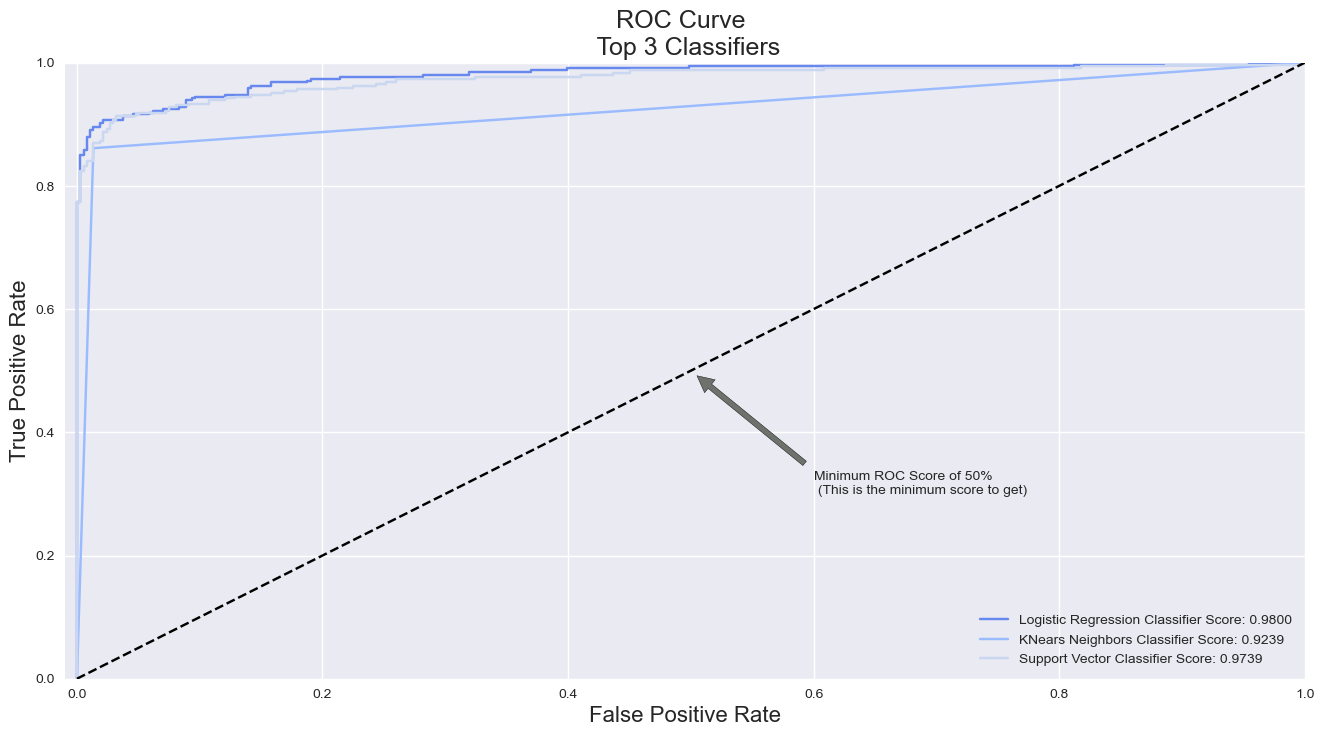

In [15]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)

def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 3 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr)
plt.show()

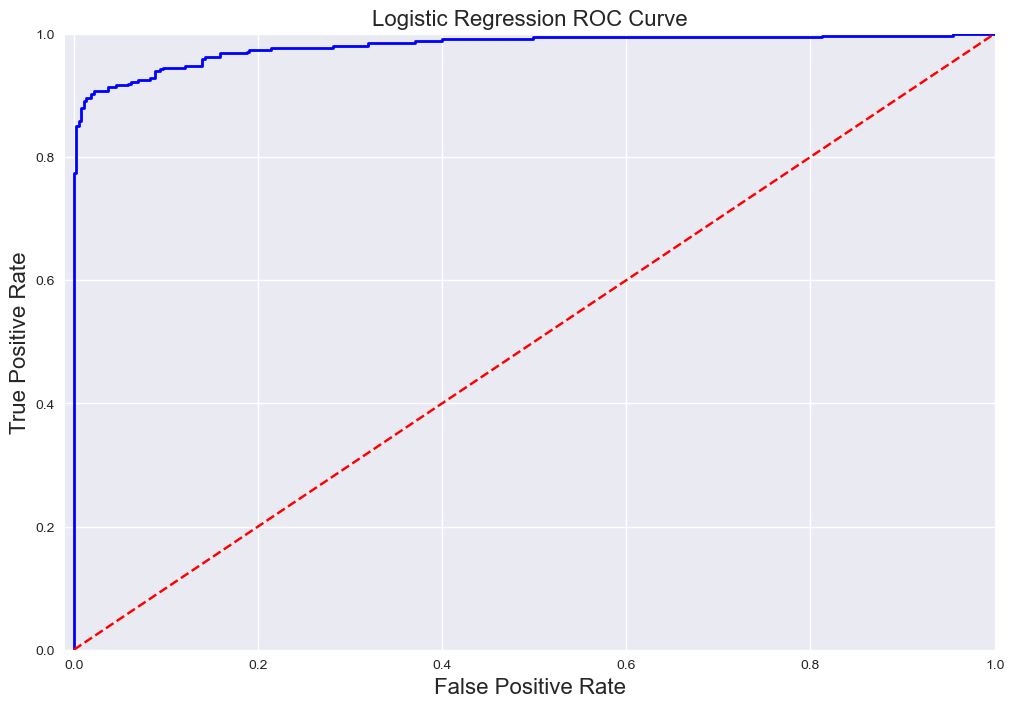

In [16]:
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
    
logistic_roc_curve(log_fpr, log_tpr)
plt.show()

In [17]:

precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)



In [18]:
y_pred = log_reg.predict(X_train)

# Overfitting Case
print('---' * 45)
print('performance on the training data: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 45)

# How it should look like
print('---' * 45)
print('average cross-validation performance:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
performance on the training data: 

Recall Score: 0.91
Precision Score: 0.96
F1 Score: 0.94
Accuracy Score: 0.94
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
average cross-validation performance:

Accuracy Score: 0.97
Precision Score: 0.99
Recall Score: 0.96
F1 Score: 0.97
---------------------------------------------------------------------------------------------------------------------------------------


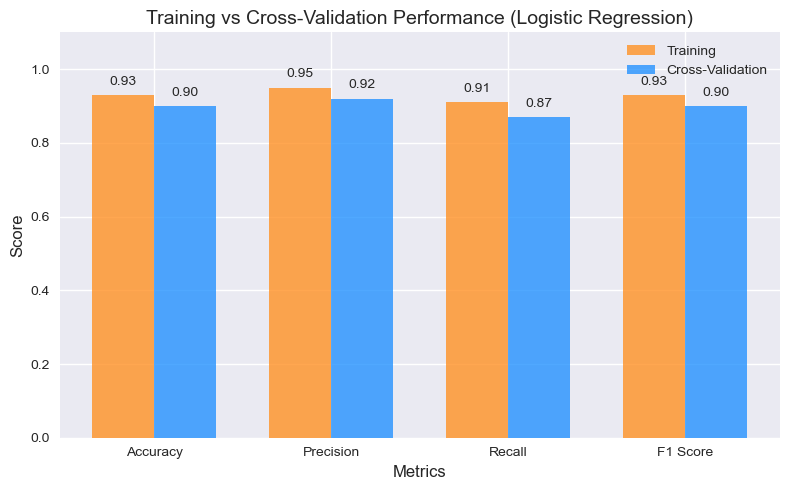

In [19]:



train_metrics = {
    'Accuracy': 0.93,
    'Precision': 0.95,
    'Recall': 0.91,
    'F1 Score': 0.93
}

cv_metrics = {
    'Accuracy': 0.90,
    'Precision': 0.92,
    'Recall': 0.87,
    'F1 Score': 0.90
}


metrics = list(train_metrics.keys())
train_values = list(train_metrics.values())
cv_values = list(cv_metrics.values())

x = np.arange(len(metrics))  
width = 0.35  

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, train_values, width, label='Training', color='#ff9124', alpha=0.8)
bars2 = ax.bar(x + width/2, cv_values, width, label='Cross-Validation', color='#2492ff', alpha=0.8)


ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Training vs Cross-Validation Performance (Logistic Regression)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.1)
ax.legend()


for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', 
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [25]:
original_Xtest = pd.read_csv("../data/processed/x_test_original.csv").values
original_ytest = pd.read_csv("../data/processed/y_test_original.csv").values
original_ytrain = pd.read_csv("../data/processed/y_train_original.csv").values
original_Xtrain = pd.read_csv("../data/processed/x_train_original.csv").values


In [21]:
undersample_y_score = log_reg.decision_function(original_Xtest)

In [22]:
from sklearn.metrics import average_precision_score
undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      undersample_average_precision))

Average precision-recall score: 0.26


Text(0.5, 1.0, 'UnderSampling Precision-Recall curve: \n Average Precision-Recall Score =0.26')

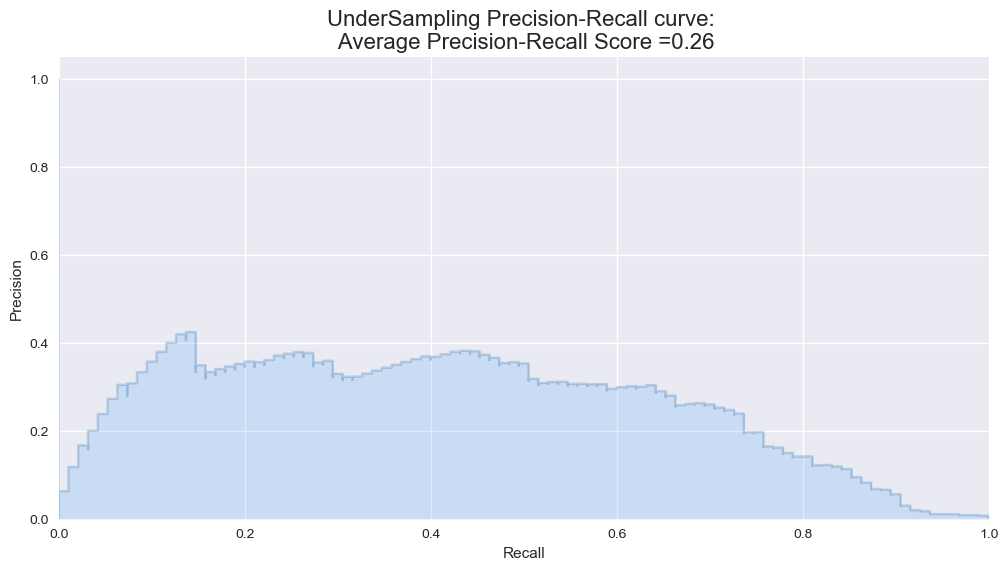

In [23]:

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          undersample_average_precision), fontsize=16)

model detects almost all frauds (high recall)
but marks nearly everything as fraud (very low precision).

So it’s over-alerting — catching nearly all true frauds but with tons of false alarms.

*** Oversampled data

In [26]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV


print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()




rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

Length of X (train): 226981 | Length of y (train): 226981
Length of X (test): 56745 | Length of y (test): 56745
---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9772451924135956
precision: 0.06221408966148216
recall: 0.8947368421052632
f1: 0.11633875106929
---------------------------------------------------------------------------------------------------------------------------------------


In [27]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))
print('confusion matrix: \n', confusion_matrix(original_ytest, smote_prediction))

              precision    recall  f1-score   support

    No Fraud       1.00      0.99      0.99     56650
       Fraud       0.11      0.87      0.19        95

    accuracy                           0.99     56745
   macro avg       0.55      0.93      0.59     56745
weighted avg       1.00      0.99      0.99     56745

confusion matrix: 
 [[55974   676]
 [   12    83]]


In [28]:
y_score = best_est.decision_function(original_Xtest)

In [29]:
average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.76


Text(0.5, 1.0, 'OverSampling Precision-Recall curve: \n Average Precision-Recall Score =0.76')

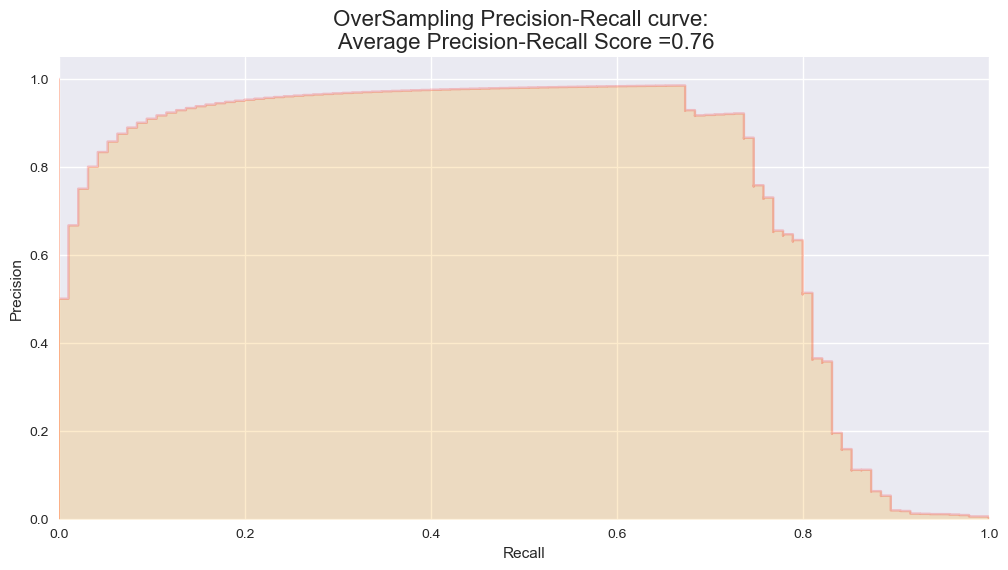

In [30]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

In [32]:
sm = SMOTE(sampling_strategy='minority', random_state=42)

Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)


In [33]:
import time 
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :4.109412670135498 sec


## XGBoost Classifier on SMOTE data 

In [34]:
df_smote = pd.DataFrame(Xsm_train, columns=df.columns[:-1])
df_smote['Class'] = ysm_train

In [35]:
df_smote.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.774718,-0.995290,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.268530,-0.995290,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.959811,-0.995279,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.411487,-0.995279,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.667362,-0.995267,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [36]:
df_smote.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453206 entries, 0 to 453205
Data columns (total 31 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   scaled_amount  453206 non-null  float64
 1   scaled_time    453206 non-null  float64
 2   V1             453206 non-null  float64
 3   V2             453206 non-null  float64
 4   V3             453206 non-null  float64
 5   V4             453206 non-null  float64
 6   V5             453206 non-null  float64
 7   V6             453206 non-null  float64
 8   V7             453206 non-null  float64
 9   V8             453206 non-null  float64
 10  V9             453206 non-null  float64
 11  V10            453206 non-null  float64
 12  V11            453206 non-null  float64
 13  V12            453206 non-null  float64
 14  V13            453206 non-null  float64
 15  V14            453206 non-null  float64
 16  V15            453206 non-null  float64
 17  V16            453206 non-nul

In [37]:
from sklearn.decomposition import PCA
pca = PCA().fit(Xsm_train)
np.cumsum(pca.explained_variance_ratio_)

array([0.71251983, 0.80242361, 0.86323018, 0.90240893, 0.93372454,
       0.94290841, 0.95014855, 0.95585402, 0.96100988, 0.96536919,
       0.969057  , 0.97251284, 0.97560243, 0.97859714, 0.98119917,
       0.98374214, 0.98612718, 0.98830252, 0.99032356, 0.99210206,
       0.99376455, 0.99498271, 0.99613405, 0.99712274, 0.99789238,
       0.99857768, 0.9990761 , 0.9994685 , 0.99974788, 1.        ])

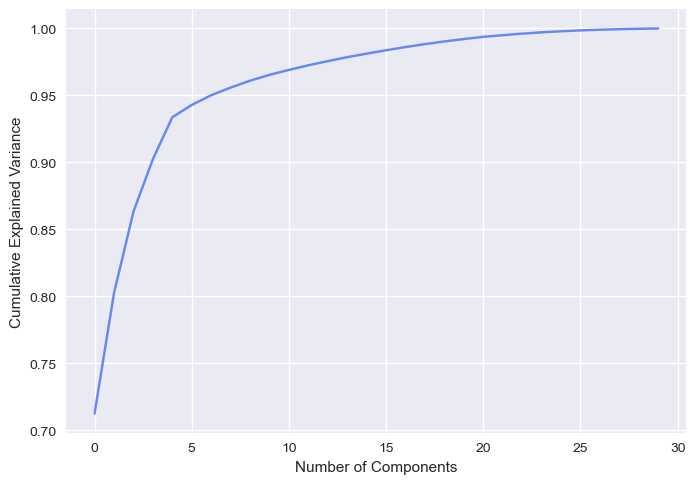

In [38]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [ ]:
pca = PCA(n_components=0.95)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

print(pca.n_components_)


12


In [4]:
df=pd.read_csv("../data/raw/creditcard.csv")
x=df.drop('Class', axis=1)
y=df['Class']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [5]:
from sklearn.pipeline  import Pipeline
from sklearn.decomposition import PCA
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=12)),
    ('model',XGBClassifier())
])



In [6]:
from sklearn.metrics import make_scorer
from sklearn.metrics import average_precision_score
scoring = {
    'precision': make_scorer(precision_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'f1': make_scorer(f1_score, pos_label=1),
    'roc_auc': 'roc_auc',
    'pr_auc': make_scorer(average_precision_score, needs_proba=True)
}

In [7]:
from sklearn.model_selection import StratifiedKFold, cross_validate

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_validate(
    pipeline, X_train, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

print({k: scores[k].mean() for k in scores})

{'fit_time': 11.921595287322997, 'score_time': 0.5891000747680664, 'test_precision': 0.5219047619047619, 'test_recall': 0.4016877637130801, 'test_f1': 0.453041754209172, 'test_roc_auc': 0.7325860214906958, 'test_pr_auc': 0.40489810666781123}


In [8]:
param_grid = {
    'model__n_estimators': [300, 500],
    'model__max_depth': [4, 6, 8],
    'model__learning_rate': [0.05, 0.1],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0],
    'model__scale_pos_weight': [5, 10, 20]  # adjust for imbalance
}


In [13]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    cv=cv,
    scoring='recall',      
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best Recall:", grid.best_score_)
print("Best Estimator:", grid.best_estimator_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'model__subsample': 1.0, 'model__scale_pos_weight': 10, 'model__n_estimators': 300, 'model__max_depth': 4, 'model__learning_rate': 0.1, 'model__colsample_bytree': 1.0}
Best Recall: 0.7614410905550146
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=12)),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, le

In [14]:
best_pipeline = grid.best_estimator_
best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=12)),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [15]:
y_pred = best_pipeline.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.80      0.82        98

    accuracy                           1.00     56962
   macro avg       0.92      0.90      0.91     56962
weighted avg       1.00      1.00      1.00     56962

[[56850    14]
 [   20    78]]


this is the highest recall i've ever get on this dataset next we will try smth else to boost the score metric even higher 

In [19]:
y_proba = best_pipeline.predict_proba(X_test)[:, 1]


recalls = recall_score(y_test, (y_proba > 0).astype(int)) 


print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.80      0.82        98

    accuracy                           1.00     56962
   macro avg       0.92      0.90      0.91     56962
weighted avg       1.00      1.00      1.00     56962

[[56850    14]
 [   20    78]]


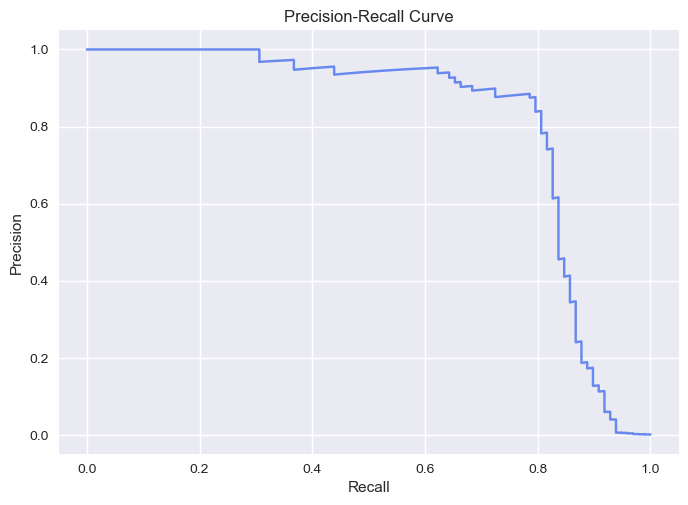

In [20]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

## Final Interpretation 



✔ Excellent detection performance

Detects 80% of frauds

Very few false alarms (14 out of 56k transactions)

Very high precision (85%)

✔ Extremely low error on normal transactions

Almost never misclassifies legitimate transactions.

✔ Excellent balanced fraud score

F1 = 0.82, very strong for imbalanced data.